# Comparison of GNN results with REF15

1. Compare results of best model from hyperparameter tuning with REF15 for AbAg-affinity test set and AB-benchmark

2. Check how robust GNN ist on 4-Fold Cross Validation

In [1]:
import pandas as pd
import os
from collections import defaultdict
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from abag_affinity.utils.config import read_config, get_data_paths
from pathlib import Path
from scipy.stats import norm
import seaborn as sns

In [2]:
project_root = "../.."
plot_path = os.path.join(project_root, "results", "experiments", "GNN_REF15_comparison_test_set")
Path(plot_path).mkdir(exist_ok=True, parents=True)

gnn_abag_test_result_path = os.path.join(project_root, "results/predictions/CV_experiment/abag_affinity_test_cv1.csv")
gnn_ab_benchmark_result_path = os.path.join(project_root, "results/predictions/CV_experiment/benchmark_cv1.csv")
col_mapping = {
    "prediction": "gnn_prediction",
    "labels": "-log(Kd)_labels"
}
gnn_abag_test_df = pd.read_csv(gnn_abag_test_result_path, index_col=0).set_index("pdb").rename(col_mapping, axis=1)
gnn_ab_benchmark_df = pd.read_csv(gnn_ab_benchmark_result_path, index_col=0).set_index("pdb").rename(col_mapping, axis=1)

In [3]:
config = read_config("../config.yaml")
force_field_results_folder = config["force_field_results"]
assumed_temp = 298.15
gas_constant =  8.31446261815324 

def get_scores(path):
    # get pdb_ids
    with open(os.path.join(path, "data_points.txt")) as f:
        pdbs = f.readlines()
    pdbs = [ pdb.split(",")[0].strip().lower() for pdb in pdbs]

    # get delta g scores
    with open(os.path.join(path, "results.txt")) as f:
        scores = f.readlines()

    results = defaultdict(dict)
    pdb_idx = 0
    for score in scores:
        if score == 'Antibody\n':
            score_type = "Antibody"
        if score == 'Antigen\n':
            score_type = "Antigen"
        if score == 'Complex\n':
            score_type = "Complex"
        if score in ["\n", 'Antibody\n', 'Antigen\n', 'Complex\n', 'fa_atr\n', 'score\n']:
            pdb_idx = 0
            continue
            
        results[pdbs[pdb_idx]][score_type] = score.strip()
        pdb_idx += 1

    rosetta_scores = pd.DataFrame(results.values())
    rosetta_scores.index = results.keys()
    rosetta_scores = rosetta_scores.astype(float)
    rosetta_scores["rosetta_delta_g"] = rosetta_scores["Complex"] - rosetta_scores["Antibody"] - rosetta_scores["Antigen"]
    
    return rosetta_scores

In [4]:
num_bootstrap_repeats = 10000

def calculate_and_plot_bootstraped_error_differences(df):
    # based on https://stats.stackexchange.com/questions/518773/statistical-test-for-comparing-performance-metrics-of-two-regression-models-on-a
    bootstrapped_mean_diff = [ df["error_diff"].sample(n=len(benchmark_results), replace=True).mean() for _ in range(num_bootstrap_repeats)]
    ci = norm(*norm.fit(bootstrapped_mean_diff)).interval(0.95)  # fit a normal distribution and get 95% c.i.
    sns.histplot(bootstrapped_mean_diff, bins=50)
    plt.axvline(ci[0], color="red")
    plt.axvline(ci[1], color="red")
    
    plt.xlabel("Mean of difference of absolute prediction errors")
    plt.title(f"Histogram of mean differences of absolute prediction erros - {num_bootstrap_repeats} bootstrapped samples")
    return ci


def calculate_and_plot_bootstraped_metrics(df):
    # based on https://stats.stackexchange.com/questions/518773/statistical-test-for-comparing-performance-metrics-of-two-regression-models-on-a
    fig, ax = plt.subplots(1,2, figsize=(15,5))

    bootstrapped_dfs = [ df[["delta_g_labels", "-log(Kd)_labels", "ref15_prediction", "rosetta_delta_g", "gnn_prediction"]].sample(
        n=len(benchmark_results), replace=True) for _ in range(num_bootstrap_repeats)]
    
    
    # calculate and plot rsme
    rsme = [ np.sqrt(np.mean((sample_df["gnn_prediction"]-sample_df["-log(Kd)_labels"])**2)) -
              np.sqrt(np.mean((sample_df["ref15_prediction"]-sample_df["-log(Kd)_labels"])**2))
            for sample_df in bootstrapped_dfs]

    ci_rsme = norm(*norm.fit(rsme)).interval(0.9)  # fit a normal distribution and get 95% c.i.
    sns.histplot(rsme, bins=50, ax=ax[0])
    #ax[0].axvline(ci_rsme[0], color="red")
    ax[0].axvline(ci_rsme[1], color="red")
    ax[0].set_xlabel("Difference of root-mean-squared-errors")

    
    # calculate and plot pearson    
    pearson = [ stats.pearsonr(x=sample_df["gnn_prediction"], y=sample_df["-log(Kd)_labels"])[0] - 
              stats.pearsonr(x=sample_df["rosetta_delta_g"], y=sample_df["delta_g_labels"])[0]
            for sample_df in bootstrapped_dfs]
    
    ci_pearson = norm(*norm.fit(pearson)).interval(0.95)  # fit a normal distribution and get 95% c.i.
    sns.histplot(pearson, bins=50, ax=ax[1])
    ax[1].axvline(ci_pearson[0], color="red")
    ax[1].axvline(ci_pearson[1], color="red")
    ax[1].set_xlabel("Difference of pearson correlations")
    plt.suptitle(f"Histogram of RSME and Pearson's R differences - {num_bootstrap_repeats} bootstrapped samples")
    return ci_rsme, ci_pearson

In [5]:
# fit linear transform for REF 15 values based on abag_affinity dataset
from sklearn.linear_model import LinearRegression

abag_rosetta_scores = get_scores(os.path.join(force_field_results_folder, "guest_REF15", "abag_affinity_dataset"))

abag_summary_path = os.path.join(config["DATASETS"]["path"], config["DATASETS"]["abag_affinity"]["folder_path"], config["DATASETS"]["abag_affinity"]["summary"])
abag_df = pd.read_csv(abag_summary_path, index_col=0)
abag_df = abag_df[~abag_df["test"] & ~abag_df["delta_g"].isna()]

overlap_df = abag_df.join(abag_rosetta_scores)

X = overlap_df["rosetta_delta_g"].values.reshape(-1, 1)
y = overlap_df["delta_g"].values.reshape(-1, 1)

rosetta_fit = LinearRegression().fit(X, y)

In [6]:
def calc_kd(delta_g):
    delta_g = rosetta_fit.predict(np.array(delta_g).reshape(1,-1)).item() # scale value
    
    delta_g = delta_g * 4184 # convert to cal  
    
    kd = 1 / np.exp(-delta_g / ( gas_constant * assumed_temp))
    return kd

def calc_delta_g(kd):
    delta_g = -1 * gas_constant * assumed_temp * np.log(1 / kd)
    return delta_g / 4184 # convert to kcal

In [7]:
benchmark_ref15_scores = get_scores(os.path.join(force_field_results_folder, "guest_REF15", "antibody_benchmark"))
benchmark_ref15_scores["ref15_kd_prediction"] = benchmark_ref15_scores["rosetta_delta_g"].apply(calc_kd) 
benchmark_ref15_scores["ref15_prediction"] = benchmark_ref15_scores["ref15_kd_prediction"].apply(lambda x: -np.log10(x)) 

abag_rosetta_scores = get_scores(os.path.join(force_field_results_folder, "guest_REF15", "abag_affinity_dataset"))
abag_rosetta_scores["ref15_kd_prediction"] = abag_rosetta_scores["rosetta_delta_g"].apply(calc_kd) 
abag_rosetta_scores["ref15_prediction"] = abag_rosetta_scores["ref15_kd_prediction"].apply(lambda x: -np.log10(x)) 

## AB-benchmark

### Calculate difference to predictions

In [8]:
benchmark_results = gnn_ab_benchmark_df.join(benchmark_ref15_scores)[["gnn_prediction", "-log(Kd)_labels", "ref15_prediction", "rosetta_delta_g"]]
benchmark_results["delta_g_labels"] = benchmark_results["-log(Kd)_labels"].apply(lambda x: calc_delta_g(10**(-x)))

benchmark_results["gnn_diff"] = benchmark_results["gnn_prediction"] - benchmark_results["-log(Kd)_labels"]
benchmark_results["gnn_error"] = np.abs(benchmark_results["gnn_diff"])

benchmark_results["ref15_diff"] = benchmark_results["ref15_prediction"] - benchmark_results["-log(Kd)_labels"]
benchmark_results["ref15_error"] = np.abs(benchmark_results["ref15_diff"])

benchmark_results["error_diff"] = benchmark_results["gnn_error"] - benchmark_results["ref15_error"]

In [9]:
benchmark_results.describe()

,gnn_prediction,-log(Kd)_labels,ref15_prediction,rosetta_delta_g,delta_g_labels,gnn_diff,gnn_error,ref15_diff,ref15_error,error_diff
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,8.480250,8.686739,8.299154,-29.965548,-11.850858,-0.206489,1.095093,-0.387585,1.203936,-0.108843
std,0.299357,1.428948,0.044284,11.946086,1.949438,1.311566,0.731713,1.414340,0.818186,0.302396
min,7.767093,5.327902,8.214848,-55.240000,-15.218042,-2.375641,0.007774,-2.771966,0.018060,-0.873146
25%,8.300738,7.790935,8.269942,-36.232750,-13.465827,-1.429074,0.432372,-1.549157,0.481521,-0.298049
50%,8.427395,8.735240,8.299702,-30.113500,-11.917025,-0.285579,0.998309,-0.443027,1.182175,-0.081313
75%,8.710715,9.870520,8.322386,-22.085250,-10.628760,0.673261,1.702004,0.486367,1.872016,0.050478
max,9.195578,11.154902,8.392845,-7.223000,-7.268575,2.970963,2.970963,2.970512,2.970512,0.781431


### Plot statistics of differences

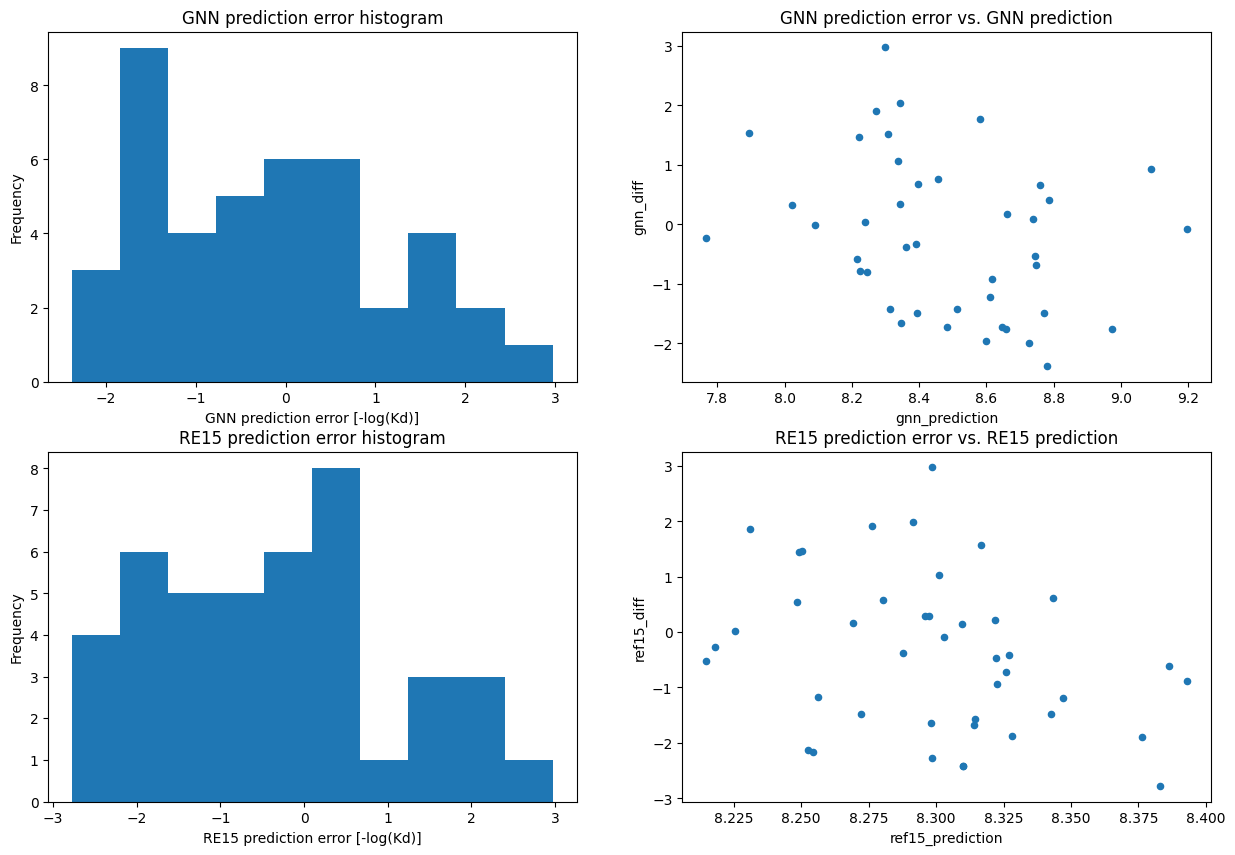

In [10]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

benchmark_results["gnn_diff"].plot.hist(ax=ax[0,0])
ax[0,0].set_title("GNN prediction error histogram")
ax[0,0].set_xlabel("GNN prediction error [-log(Kd)]")

benchmark_results.plot.scatter("gnn_prediction", "gnn_diff", ax=ax[0,1])
ax[0,1].set_title("GNN prediction error vs. GNN prediction")

benchmark_results["ref15_diff"].plot.hist(ax=ax[1,0])
ax[1,0].set_title("RE15 prediction error histogram")
ax[1,0].set_xlabel("RE15 prediction error [-log(Kd)]")

benchmark_results.plot.scatter("ref15_prediction", "ref15_diff", ax=ax[1,1])
ax[1,1].set_title("RE15 prediction error vs. RE15 prediction")

plt.savefig(os.path.join(plot_path, "ab_benchmark_error_distributions.png"))
plt.show()
plt.close()

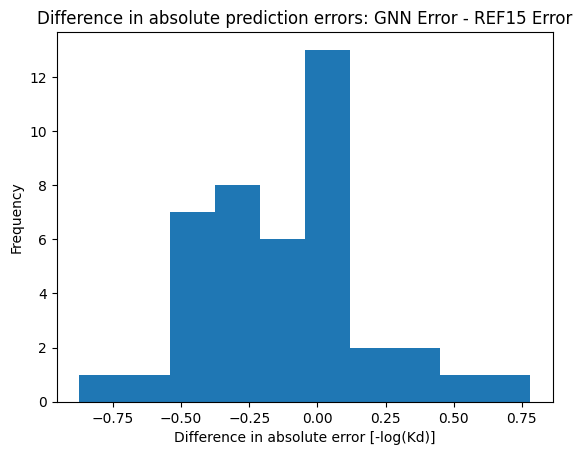

In [11]:
benchmark_results["error_diff"].plot.hist()
plt.title("Difference in absolute prediction errors: GNN Error - REF15 Error")
plt.xlabel("Difference in absolute error [-log(Kd)]")
plt.savefig(os.path.join(plot_path, "ab_benchmark_error_difference_distributions.png"))
plt.show()
plt.close()

### Bootstrapping Method to generate multiple means of differences

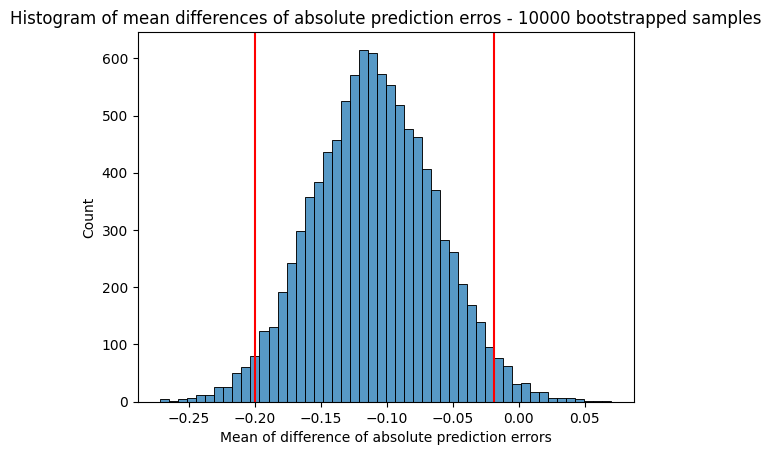

In [12]:
calculate_and_plot_bootstraped_error_differences(benchmark_results)
plt.savefig(os.path.join(plot_path, "ab_benchmark_error_difference_distributions_bootstrapped.png"))
plt.show()
plt.close()

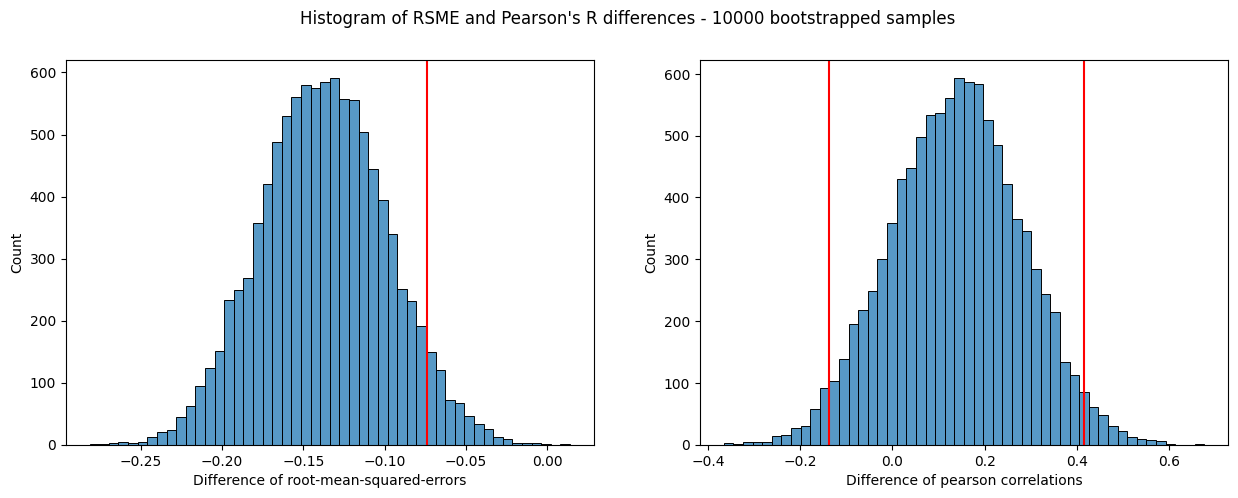

In [13]:
ci_rsme, ci_pearson = calculate_and_plot_bootstraped_metrics(benchmark_results)
plt.savefig(os.path.join(plot_path, "ab_benchmark_metric_difference_bootstrapped.png"))
plt.show()
plt.close()

In [14]:
print(ci_rsme)
print(ci_pearson)

(-0.20107246932929662, -0.07382740517202797)
(-0.13739070298968045, 0.41499266786839595)


### Calculate paired 

In [15]:
stats.wilcoxon(benchmark_results["gnn_error"], benchmark_results["ref15_error"], alternative="less")

WilcoxonResult(statistic=262.0, pvalue=0.0089074197247545)

## AbAg-Affinity test set

### Calculate difference to predictions

In [16]:
abag_test_results = gnn_abag_test_df.join(abag_rosetta_scores, how="inner")[["gnn_prediction", "-log(Kd)_labels", "ref15_prediction", "rosetta_delta_g"]]
abag_test_results["delta_g_labels"] = abag_test_results["-log(Kd)_labels"].apply(lambda x: calc_delta_g(10**(-x)))


abag_test_results["gnn_diff"] = abag_test_results["gnn_prediction"] - abag_test_results["-log(Kd)_labels"]
abag_test_results["gnn_error"] = np.abs(abag_test_results["gnn_diff"])

abag_test_results["ref15_diff"] = abag_test_results["ref15_prediction"] - abag_test_results["-log(Kd)_labels"]
abag_test_results["ref15_error"] = np.abs(abag_test_results["ref15_diff"])

abag_test_results["error_diff"] = abag_test_results["gnn_error"] - abag_test_results["ref15_error"]

In [17]:
abag_test_results.describe()

,gnn_prediction,-log(Kd)_labels,ref15_prediction,rosetta_delta_g,delta_g_labels,gnn_diff,gnn_error,ref15_diff,ref15_error,error_diff
count,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,8.197034,8.118242,8.180026,2.17078,-11.075287,0.078792,0.911217,0.061784,1.085217,-0.174000
std,0.466128,1.257807,0.840398,226.70796,1.715960,1.184440,0.749647,1.549917,1.097454,0.935005
min,6.919197,5.886057,2.365005,-55.58800,-15.271136,-2.987763,0.019570,-6.292572,0.004782,-5.899247
25%,8.126681,7.329157,8.275785,-37.60675,-12.044851,-0.612380,0.390435,-0.587837,0.263324,-0.160538
50%,8.274184,8.068101,8.306323,-31.89950,-11.006882,0.201545,0.649762,0.222947,0.854852,-0.034952
75%,8.430247,8.828937,8.327479,-23.66150,-9.998781,0.641022,1.247487,0.910399,1.636069,0.131562
max,9.266916,11.193820,8.394135,1570.84500,-8.030035,2.302698,2.987763,2.443982,6.292572,1.140020


### Plot statistics of differences

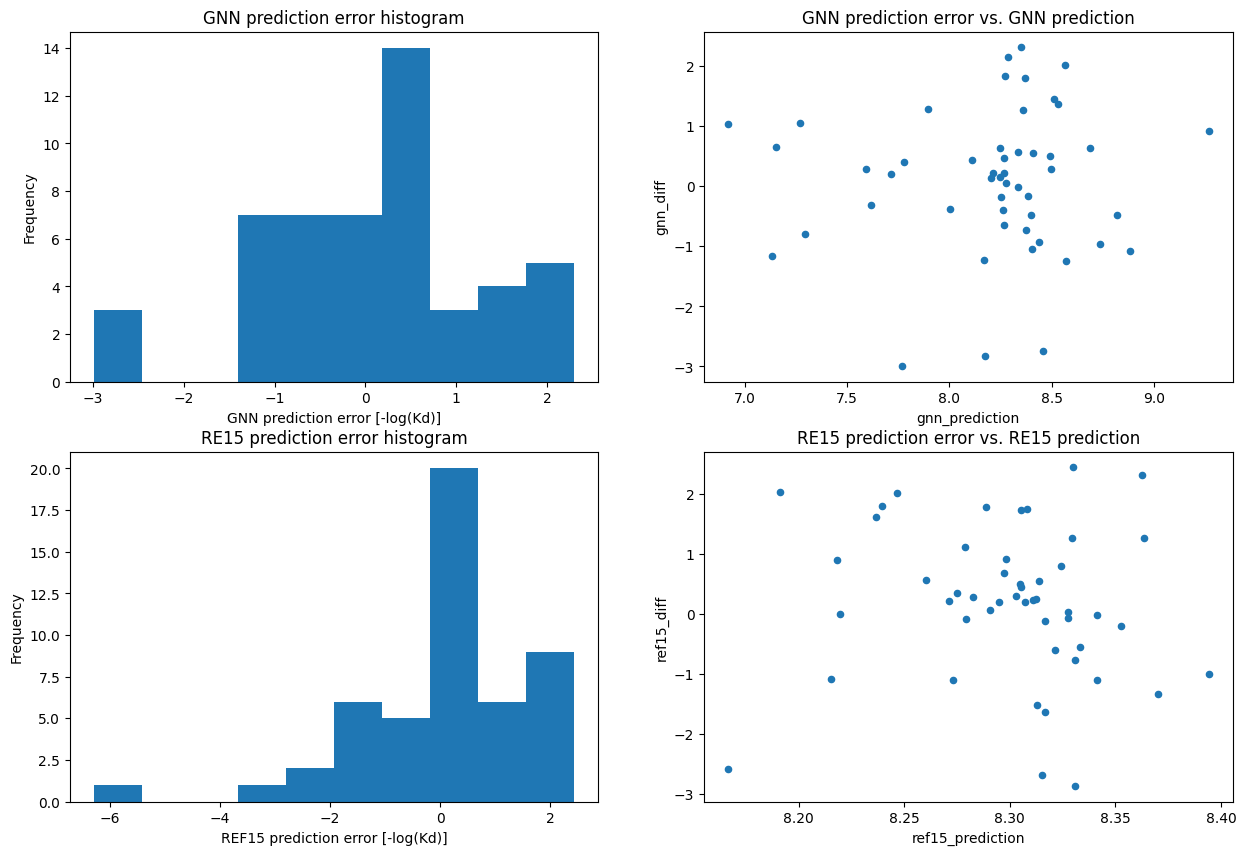

In [18]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

abag_test_results["gnn_diff"].plot.hist(ax=ax[0,0])
ax[0,0].set_title("GNN prediction error histogram")
ax[0,0].set_xlabel("GNN prediction error [-log(Kd)]")

abag_test_results.plot.scatter("gnn_prediction", "gnn_diff", ax=ax[0,1])
ax[0,1].set_title("GNN prediction error vs. GNN prediction")

abag_test_results["ref15_diff"].plot.hist(ax=ax[1,0])
ax[1,0].set_title("RE15 prediction error histogram")
ax[1,0].set_xlabel("REF15 prediction error [-log(Kd)]")

abag_test_results[abag_test_results["rosetta_delta_g"] < 200].plot.scatter("ref15_prediction", "ref15_diff", ax=ax[1,1])
ax[1,1].set_title("RE15 prediction error vs. RE15 prediction")

plt.savefig(os.path.join(plot_path, "abag_testset_error_distributions.png"))
plt.show()
plt.close()

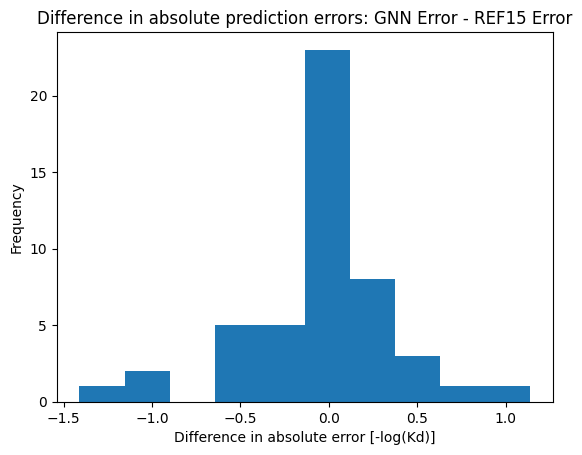

In [19]:
abag_test_results[abag_test_results["rosetta_delta_g"] < 200]["error_diff"].plot.hist()
plt.title("Difference in absolute prediction errors: GNN Error - REF15 Error")
plt.xlabel("Difference in absolute error [-log(Kd)]")
plt.savefig(os.path.join(plot_path, "abag_test_error_difference_distributions.png"))
plt.show()
plt.close()

### Bootstrapping Method to generate multiple means of differences

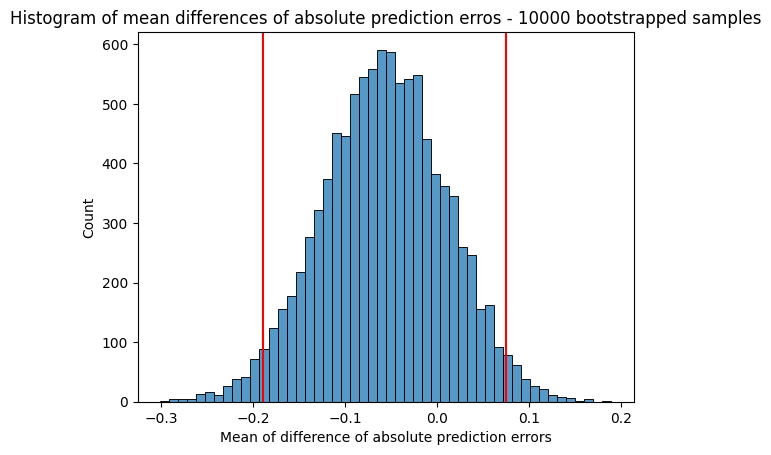

In [20]:
calculate_and_plot_bootstraped_error_differences(abag_test_results[abag_test_results["rosetta_delta_g"] < 200])
plt.savefig(os.path.join(plot_path, "abag_test_error_difference_distributions_bootstrapped.png"))
plt.show()
plt.close()

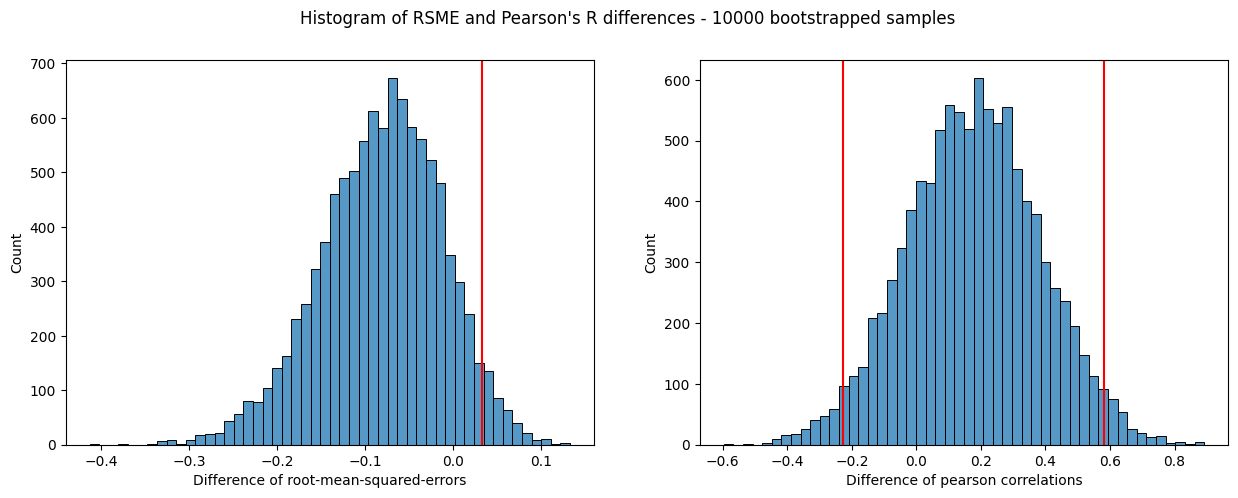

In [21]:
ci_rsme, ci_pearson = calculate_and_plot_bootstraped_metrics(abag_test_results[abag_test_results["rosetta_delta_g"] < 200])
plt.savefig(os.path.join(plot_path, "abag_test_metric_difference_bootstrapped.png"))
plt.show()
plt.close()

In [22]:
print(ci_rsme)
print(ci_pearson)

(-0.19527972009027145, 0.032517386925120156)
(-0.22877875389111482, 0.5822598599465046)


### Calculate paired T-Test

In [23]:
stats.wilcoxon(abag_test_results["gnn_error"], abag_test_results["ref15_error"], alternative="less")

WilcoxonResult(statistic=547.0, pvalue=0.19116214688152383)

## Combination of both datasets

In [24]:
full_results = pd.concat([abag_test_results, benchmark_results])
full_results.describe()

,gnn_prediction,-log(Kd)_labels,ref15_prediction,rosetta_delta_g,delta_g_labels,gnn_diff,gnn_error,ref15_diff,ref15_error,error_diff
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,8.326328,8.377773,8.234410,-12.500152,-11.429352,-0.051445,0.995161,-0.143363,1.139415,-0.144254
std,0.421296,1.361223,0.620276,167.327179,1.857045,1.245335,0.743173,1.498475,0.976561,0.716245
min,6.919197,5.327902,2.365005,-55.588000,-15.271136,-2.987763,0.007774,-6.292572,0.004782,-5.899247
25%,8.223689,7.595561,8.272705,-37.295750,-12.788975,-0.921898,0.391152,-1.095857,0.338434,-0.275590
50%,8.347982,8.218260,8.305153,-31.584000,-11.211736,0.042899,0.802822,0.022242,0.974490,-0.042166
75%,8.572433,9.374384,8.326327,-22.830750,-10.362222,0.666339,1.492688,0.708244,1.734225,0.069076
max,9.266916,11.193820,8.394135,1570.845000,-7.268575,2.970963,2.987763,2.970512,6.292572,1.140020


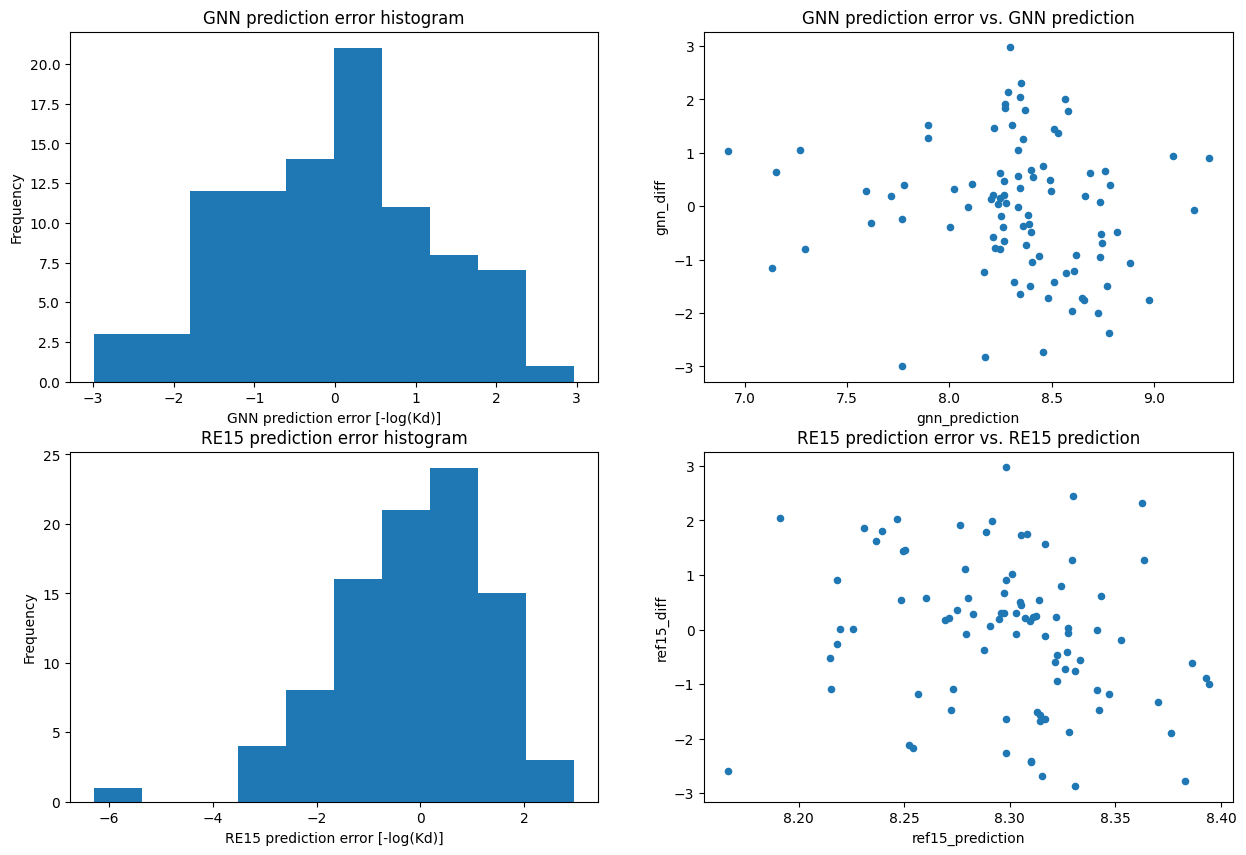

In [25]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

full_results["gnn_diff"].plot.hist(ax=ax[0,0])
ax[0,0].set_title("GNN prediction error histogram")
ax[0,0].set_xlabel("GNN prediction error [-log(Kd)]")


full_results.plot.scatter("gnn_prediction", "gnn_diff", ax=ax[0,1])
ax[0,1].set_title("GNN prediction error vs. GNN prediction")

full_results["ref15_diff"].plot.hist(ax=ax[1,0])
ax[1,0].set_title("RE15 prediction error histogram")
ax[1,0].set_xlabel("RE15 prediction error [-log(Kd)]")


full_results[full_results["ref15_prediction"] > 3].plot.scatter("ref15_prediction", "ref15_diff", ax=ax[1,1])
#full_results.plot.scatter("ref15_prediction", "ref15_diff", ax=ax[1,1])

ax[1,1].set_title("RE15 prediction error vs. RE15 prediction")


plt.savefig(os.path.join(plot_path, "full_testset_error_distributions.png"))
plt.show()
plt.close()

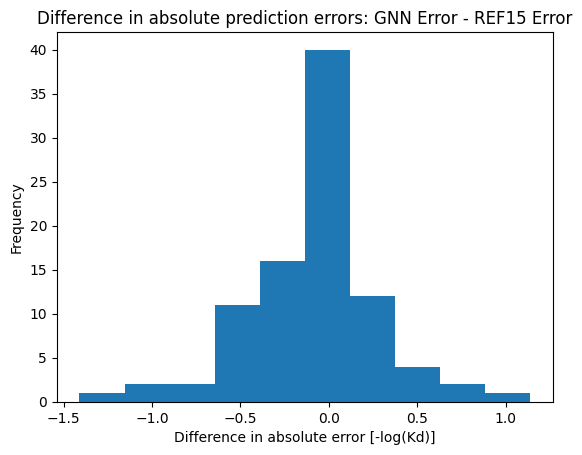

In [26]:
full_results[full_results["ref15_prediction"] > 3]["error_diff"].plot.hist()
plt.title("Difference in absolute prediction errors: GNN Error - REF15 Error")
plt.xlabel("Difference in absolute error [-log(Kd)]")
plt.savefig(os.path.join(plot_path, "full_testset_error_difference_distributions.png"))
plt.show()
plt.close()

### Bootstrapping Method to generate multiple means of differences

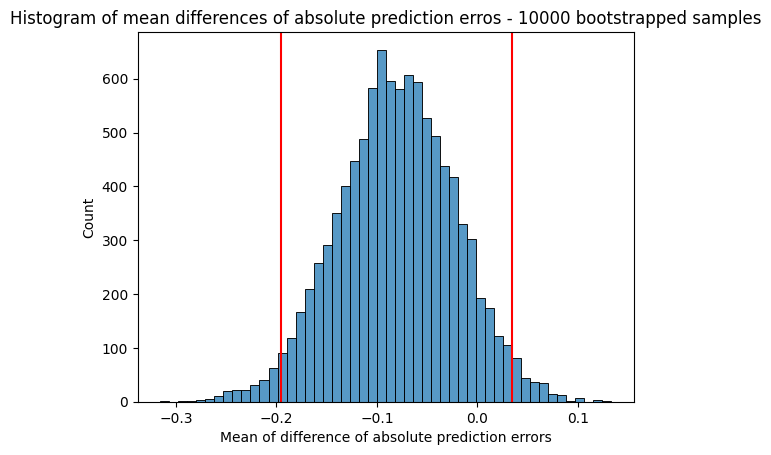

In [27]:
calculate_and_plot_bootstraped_error_differences(full_results[full_results["ref15_prediction"] > 3])
plt.savefig(os.path.join(plot_path, "full_testset_error_difference_distributions_bootstrapped.png"))
plt.show()
plt.close()

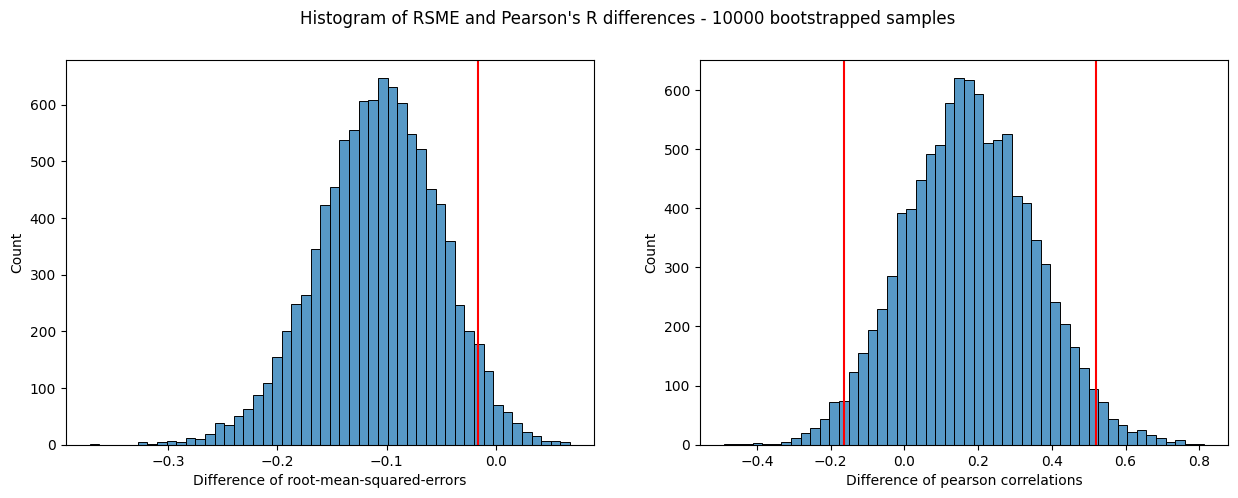

In [28]:
ci_rsme, ci_pearson = calculate_and_plot_bootstraped_metrics(full_results[full_results["ref15_prediction"] > 3])
plt.savefig(os.path.join(plot_path, "full_testset_metric_difference_bootstrapped.png"))
plt.show()
plt.close()

In [29]:
print(ci_rsme)
print(ci_pearson)

(-0.19895894333425107, -0.016062160182405916)
(-0.16404156755611554, 0.5200527880311666)


### Calculate paired T-Test

In [30]:
stats.wilcoxon(full_results["gnn_error"], full_results["ref15_error"], alternative="less")

WilcoxonResult(statistic=1565.0, pvalue=0.012705509992744302)